In [13]:
#!/usr/bin/env python
import numpy as np
import random
from tqdm import tqdm
import pickle

np.set_printoptions(precision=4, suppress=True)
# put this once near the top, after imports



# ------------------------------
# Q-Learning Code Implementation
# ------------------------------
class GridworldEnv:
    def __init__(self, grid_size=(4, 4)):
        self.rows, self.cols = grid_size
        # Define special states with forced destination and reward.
        self.special_states = {
            (0, 1): {'dest': (3, 1), 'reward': 10},
            (0, 3): {'dest': (2, 3), 'reward': 5}
        }
        # Actions: 0: left, 1: up, 2: right, 3: down.
        self.actions = {
            0: (0, -1),
            1: (-1, 0),
            2: (0, 1),
            3: (1, 0)
        }
        self.action_list = [0, 1, 2, 3]
        self.intended_prob = 0.9
        self.slip_prob = 0.05  # probability for each perpendicular move

    def in_bounds(self, state):
        r, c = state
        return 0 <= r < self.rows and 0 <= c < self.cols

    def get_perpendicular_actions(self, action):
        if action in [0, 2]:
            return [1, 3]
        elif action in [1, 3]:
            return [0, 2]
        else:
            return []

    def get_outcomes(self, state, action):
        """
        Computes all possible outcomes for a given state and action.
        Returns a list of tuples: (probability, next_state, reward)
        following the dynamics of the gridworld.
        """
        if state in self.special_states:
            forced_dest = self.special_states[state]['dest']
            reward = self.special_states[state]['reward']
            return [(1.0, forced_dest, reward)]

        outcomes = []
        intended_action = action
        base_reward = 0
        probs = [self.intended_prob, self.slip_prob, self.slip_prob]
        actions_to_consider = [intended_action] + self.get_perpendicular_actions(intended_action)
        for act, p in zip(actions_to_consider, probs):
            dr, dc = self.actions[act]
            next_state = (state[0] + dr, state[1] + dc)
            if not self.in_bounds(next_state):
                outcomes.append((p, state, -1))
            else:
                outcomes.append((p, next_state, base_reward))
        return outcomes

def compute_optimal_Q(env, gamma=0.9, tol=1e-9, max_iter=10000):
    """
    Compute the optimal Q-function Q* using value iteration.
    Returns Q* as a (rows x cols x num_actions) numpy array.
    """
    Q = np.zeros((env.rows, env.cols, len(env.action_list)))
    for it in range(max_iter):
        Q_new = np.zeros_like(Q)
        for r in range(env.rows):
            for c in range(env.cols):
                state = (r, c)
                for a in env.action_list:
                    if state in env.special_states:
                        forced_dest = env.special_states[state]['dest']
                        reward = env.special_states[state]['reward']
                        Q_new[r, c, a] = reward + gamma * np.max(Q[forced_dest[0], forced_dest[1]])
                    else:
                        probs = [env.intended_prob, env.slip_prob, env.slip_prob]
                        actions_to_consider = [a] + env.get_perpendicular_actions(a)
                        value = 0.0
                        for p, act in zip(probs, actions_to_consider):
                            dr, dc = env.actions[act]
                            next_state = (r + dr, c + dc)
                            if not env.in_bounds(next_state):
                                value += p * (-1 + gamma * np.max(Q[r, c]))
                            else:
                                value += p * (0 + gamma * np.max(Q[next_state[0], next_state[1]]))
                        Q_new[r, c, a] = value
        err = np.max(np.abs(Q_new - Q))
        Q = Q_new
        if err < tol:
            print(f"Value iteration converged in {it+1} iterations with error {err:.2e}.")
            break
    return Q

class QLearningAgent:
    def __init__(self, env, alpha_constant=0.1,alpha_diminishing=0.5, gamma=0.9):
        self.env = env
        self.alpha_constant = alpha_constant      # learning rate
        self.alpha_diminishing = alpha_diminishing 
        self.gamma = gamma      # discount factor
        #self.epsilon = epsilon  # exploration rate
        self.Q = np.zeros((env.rows, env.cols, len(env.action_list)))

        

def run_q_learning_LD2Z(Q_star,steps=2, gamma=0.7, eta=0.65, power=1, alpha_constant = 0.05,
    alpha_diminishing = 0.05, seed=None):
    env = GridworldEnv()
    agent = QLearningAgent(env, alpha_constant=alpha_constant, alpha_diminishing=alpha_diminishing, gamma=gamma)
    #Q_star = compute_optimal_Q(env, gamma=gamma)

    Q_traj = agent.Q.copy() 
    #print(Q_traj)
    # List to store copies of the Q-function.
    branch_probs = [env.intended_prob, env.slip_prob, env.slip_prob]
    error_history = []   # To record the sup-norm error after each episode
    
    partial_mean = np.zeros_like(Q_star)
    tail_partial_mean = np.zeros_like(Q_star)    
    max_norm = 0.0
    last_T = int(np.floor(np.sqrt(steps)))
    start_tail = max(0, steps - last_T)

    for t in tqdm(range(steps), desc="Linearly decaying steps", ncols=100, position=0):
        branch = np.random.choice([0, 1, 2], p=branch_probs)
        for r in range(env.rows):
            for c in range(env.cols):
                s = (r, c)
                for a in env.action_list:
                    if s in env.special_states:
                        forced_dest = env.special_states[s]['dest']
                        reward = env.special_states[s]['reward']
                        bellman_op = reward + gamma * np.max(Q_traj[forced_dest[0], forced_dest[1]])
                    else:
                        outcomes = env.get_outcomes(s, a)
                        _, s_next, r_val = outcomes[branch]
                        bellman_op = r_val + gamma * np.max(Q_traj[s_next[0], s_next[1]])
                    
                    lr = eta * ((1- t/steps)** power)
                    agent.Q[r, c, a] = (1 - lr) * agent.Q[r, c, a] + lr * bellman_op
        Q_traj = agent.Q.copy()
        #print(Q_traj)
        #error_history.append(np.max(np.abs(Q_traj - Q_star)))
        partial_mean += (Q_traj - Q_star)/steps
        if t>= start_tail:
            tail_partial_mean += (Q_traj - Q_star) / max(1, last_T)
        #print(Q_traj)
        
    sup_partial = np.max(np.abs(partial_mean))
    sup_tail = np.max(np.abs(tail_partial_mean))
    return sup_partial, sup_tail



In [14]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Experiment settings
    STEPS_LIST = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
    rng_global = np.random.default_rng(12345)
    B = 500
    num_cores = 5

    # Q-learning hyperparams
    gamma = 0.1
    eta = 0.05
    power = 1

    # Precompute Q* once for this gamma
    env_ref = GridworldEnv()
    Q_star = compute_optimal_Q(env_ref, gamma=gamma)

    # Storage
    means_partial = []
    ses_partial = []
    means_tail = []
    ses_tail = []

    # Helper: one MC replicate for a given steps
    def one_replicate(steps, base_seed, rep_idx):
        # different seed per replicate
        seed = (base_seed + 9973 * rep_idx) % (2**32 - 1)
        return run_q_learning_LD2Z(Q_star, steps=steps, gamma=gamma, eta=eta, power=power, seed=seed)

    for steps in tqdm(STEPS_LIST, desc="Over step sizes", ncols=100):
        base_seed = int(rng_global.integers(0, 2**32 - 1))
        # Parallelize across B independent replicates
        results = Parallel(n_jobs=num_cores, prefer="processes", verbose=0)(
            delayed(one_replicate)(steps, base_seed, b) for b in range(B)
        )
        arr = np.asarray(results)  # shape (B, 2)

        # Means across replicates
        mean_partial = arr[:, 0].mean()
        mean_tail = arr[:, 1].mean()

        # Standard errors (std / sqrt(B))
        se_partial = arr[:, 0].std(ddof=1) / np.sqrt(B)
        se_tail = arr[:, 1].std(ddof=1) / np.sqrt(B)

        means_partial.append(mean_partial)
        ses_partial.append(se_partial)
        means_tail.append(mean_tail)
        ses_tail.append(se_tail)

    # ------------------------------
    # Plot: mean with ±1 SE shading
    # ------------------------------
    steps_x = np.array(STEPS_LIST, dtype=float)
    means_partial = np.array(means_partial)
    ses_partial = np.array(ses_partial)
    means_tail = np.array(means_tail)
    ses_tail = np.array(ses_tail)

Value iteration converged in 11 iterations with error 5.37e-10.


Over step sizes: 100%|███████████████████████████████████████████████| 9/9 [20:29<00:00, 136.56s/it]


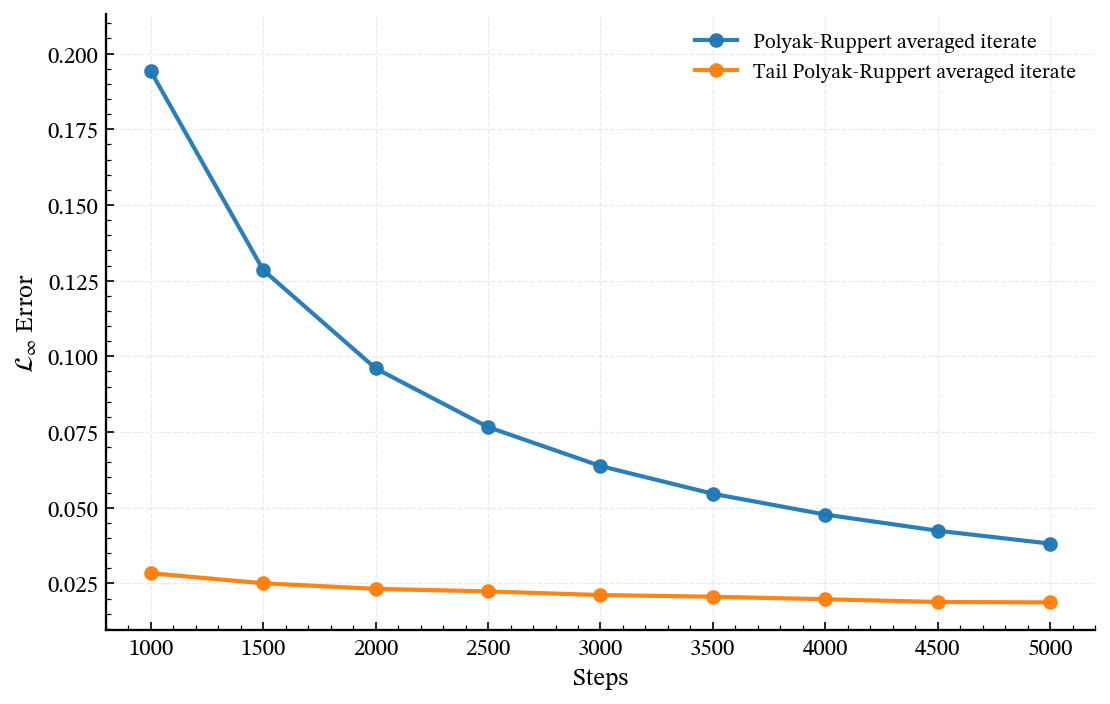

In [23]:
# -------------
# NeurIPS-style plot
# -------------

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "font.family": "serif",
    "font.serif": ["STIX Two Text", "Times New Roman", "DejaVu Serif", "STIXGeneral", "CMU Serif"],
    "mathtext.fontset": "stix",
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1.1,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": False,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "grid.linewidth": 0.6,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.minor.size": 2.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.autolayout": False,  # we'll call tight_layout explicitly
})

# ----------------

fig = plt.figure(figsize=(7.5, 4.8))
ax = plt.gca()

# Mean sup-norm of average error (+/- 1 SE)
ax.plot(steps_x, means_partial, 'o-', linewidth=2.0, label="Polyak-Ruppert averaged iterate", alpha=0.95)
ax.fill_between(steps_x,
                means_partial - ses_partial,
                means_partial + ses_partial,
                alpha=0.20)

# Mean sup-norm of tail-average error (+/- 1 SE)
ax.plot(steps_x, means_tail, 'o-',  linewidth=2.0, label="Tail Polyak-Ruppert averaged iterate", alpha=0.95)
ax.fill_between(steps_x,
                means_tail - ses_tail,
                means_tail + ses_tail,
                alpha=0.20)

ax.set_xlabel("Steps")
ax.set_ylabel(r"$\mathcal{L}_\infty$ Error")

# Slight headroom, minor ticks, compact legend in corner
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.05)
ax.minorticks_on()
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

# Save like in your template
fig.savefig("ld2z_mean_errors_vs_steps.png", bbox_inches="tight")
